# 🌊 NASA MODIS Chlorophyll-a Data Visualizer

This notebook explores and visualizes NASA MODIS Aqua chlorophyll-a data for ocean productivity analysis and potential shark habitat modeling.

**Data**: AQUA MODIS Level 3 Monthly Chlorophyll-a (4km resolution)  
**Purpose**: NASA Space Apps Challenge 2025 - Shark Habitat Prediction

## 📦 Setup and Imports

In [ ]:
# Install required packages (run once)
# !pip install netCDF4 matplotlib cartopy numpy pandas seaborn plotly

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from netCDF4 import Dataset
import pandas as pd
import seaborn as sns
from pathlib import Path
import json

# Set up plotting
plt.style.use('default')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

print("📚 Libraries loaded successfully!")

📚 Libraries loaded successfully!


## 🔍 Data Exploration

In [2]:
# Load the NetCDF file
data_file = Path('chlorophyll_data/AQUA_MODIS.20020801_20020831.L3m.MO.CHL.chlor_a.4km.nc')

print(f"📁 Loading file: {data_file.name}")
print(f"📊 File size: {data_file.stat().st_size / (1024*1024):.1f} MB")

# Open the dataset
with Dataset(data_file, 'r') as nc:
    print(f"\n📋 Dataset Information:")
    print(f"   Title: {getattr(nc, 'title', 'N/A')}")
    print(f"   Institution: {getattr(nc, 'institution', 'N/A')}")
    print(f"   Time Coverage: {getattr(nc, 'time_coverage_start', 'N/A')} to {getattr(nc, 'time_coverage_end', 'N/A')}")
    
    print(f"\n📐 Dimensions:")
    for dim_name, dim in nc.dimensions.items():
        print(f"   {dim_name}: {len(dim)}")
    
    print(f"\n🔢 Variables:")
    for var_name, var in nc.variables.items():
        print(f"   {var_name}: {var.shape} - {getattr(var, 'long_name', 'No description')}")

📁 Loading file: AQUA_MODIS.20020801_20020831.L3m.MO.CHL.chlor_a.4km.nc
📊 File size: 61.8 MB

📋 Dataset Information:
   Title: MODISA Level-3 Standard Mapped Image
   Institution: NASA Goddard Space Flight Center, Ocean Ecology Laboratory, Ocean Biology Processing Group
   Time Coverage: 2002-07-04T00:40:00.000Z to 2003-01-01T02:49:59.000Z

📐 Dimensions:
   lat: 4320
   lon: 8640
   rgb: 3
   eightbitcolor: 256

🔢 Variables:
   chlor_a: (4320, 8640) - Chlorophyll Concentration, OCI Algorithm
   lat: (4320,) - Latitude
   lon: (8640,) - Longitude
   palette: (3, 256) - No description


In [3]:
# Load coordinate and data arrays
with Dataset(data_file, 'r') as nc:
    # Load coordinates
    lat = nc.variables['lat'][:]
    lon = nc.variables['lon'][:]
    
    # Load chlorophyll data
    chlor_a = nc.variables['chlor_a'][:]
    
    # Get metadata
    chlor_units = getattr(nc.variables['chlor_a'], 'units', 'mg m^-3')
    chlor_long_name = getattr(nc.variables['chlor_a'], 'long_name', 'Chlorophyll-a')

print(f"🌍 Geographic Coverage:")
print(f"   Latitude: {lat.min():.2f}° to {lat.max():.2f}°")
print(f"   Longitude: {lon.min():.2f}° to {lon.max():.2f}°")
print(f"   Resolution: ~{abs(lat[1] - lat[0]):.3f}° (~{abs(lat[1] - lat[0]) * 111:.1f} km)")

print(f"\n🌊 Chlorophyll Data:")
print(f"   Shape: {chlor_a.shape}")
print(f"   Units: {chlor_units}")
print(f"   Description: {chlor_long_name}")

# Handle masked data (missing values)
if hasattr(chlor_a, 'mask'):
    valid_data = chlor_a[~chlor_a.mask]
    print(f"   Valid pixels: {len(valid_data):,} / {chlor_a.size:,} ({len(valid_data)/chlor_a.size*100:.1f}%)")
else:
    valid_data = chlor_a[~np.isnan(chlor_a)]
    print(f"   Valid pixels: {len(valid_data):,} / {chlor_a.size:,} ({len(valid_data)/chlor_a.size*100:.1f}%)")

if len(valid_data) > 0:
    print(f"   Data range: {valid_data.min():.4f} - {valid_data.max():.4f} {chlor_units}")
    print(f"   Mean: {valid_data.mean():.4f} {chlor_units}")
    print(f"   Median: {np.median(valid_data):.4f} {chlor_units}")

🌍 Geographic Coverage:
   Latitude: -89.98° to 89.98°
   Longitude: -179.98° to 179.98°
   Resolution: ~0.042° (~4.6 km)

🌊 Chlorophyll Data:
   Shape: (4320, 8640)
   Units: mg m^-3
   Description: Chlorophyll Concentration, OCI Algorithm
   Valid pixels: 21,290,181 / 37,324,800 (57.0%)
   Data range: 0.0021 - 86.0502 mg m^-3
   Mean: 0.4758 mg m^-3
   Median: 0.1613 mg m^-3


c:\Users\Reece\Documents\GitHub\Version-3\.venv\Lib\site-packages\numpy\_core\fromnumeric.py:867: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


## 🗺️ Global Chlorophyll Map

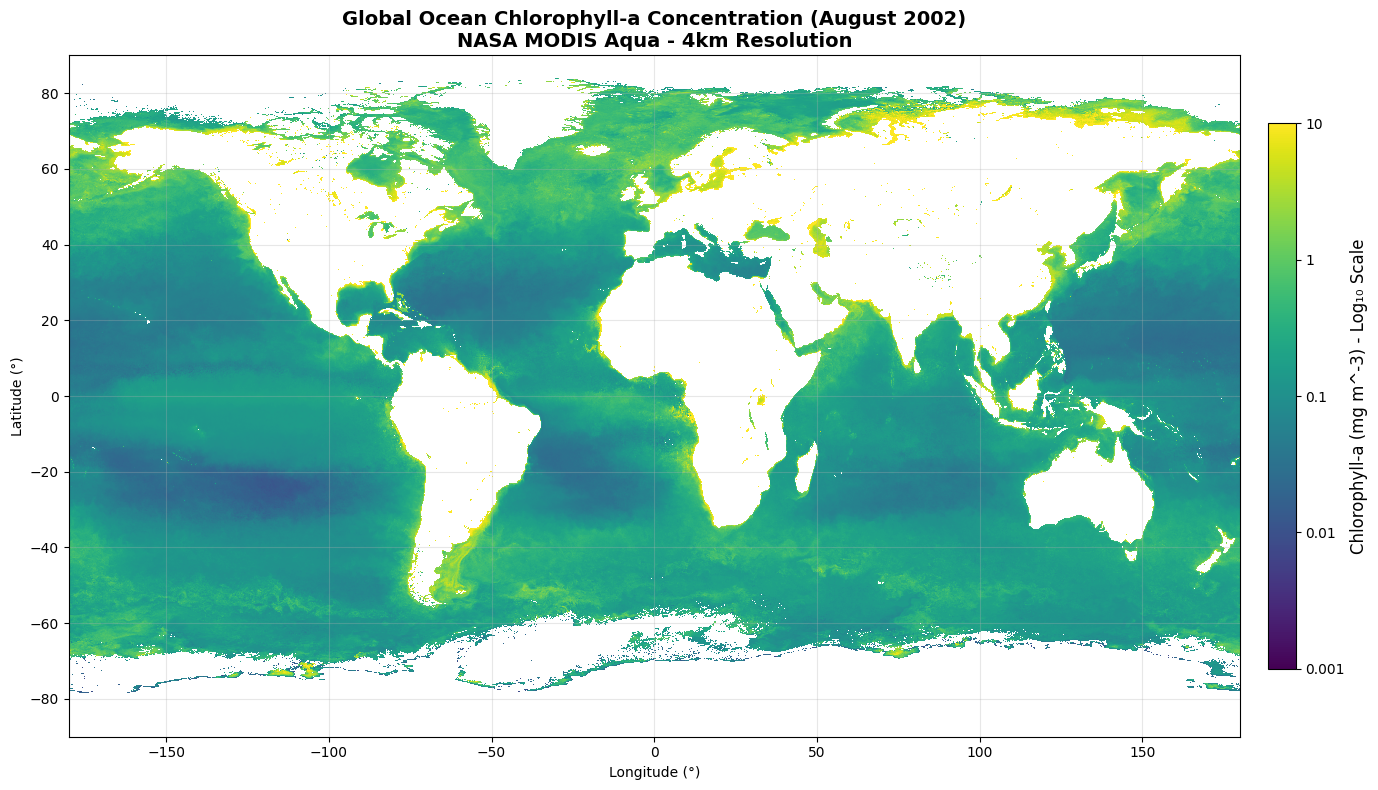

🎨 Color Scale Interpretation:
   💜 Dark Purple: Very low chlorophyll (ocean deserts)
   💙 Blue: Low chlorophyll (open ocean)
   💚 Green: Medium chlorophyll (productive waters)
   💛 Yellow: High chlorophyll (coastal upwelling, blooms)


In [4]:
# Create global chlorophyll map
fig, ax = plt.subplots(1, 1, figsize=(15, 8))

# Create meshgrid for plotting
lon_grid, lat_grid = np.meshgrid(lon, lat)

# Handle masked data for plotting
if hasattr(chlor_a, 'mask'):
    plot_data = np.ma.filled(chlor_a, np.nan)
else:
    plot_data = chlor_a

# Use log scale for chlorophyll (typical for ocean data)
# Set minimum value to avoid log(0)
plot_data_log = np.log10(np.maximum(plot_data, 0.001))

# Create the plot
im = ax.pcolormesh(lon_grid, lat_grid, plot_data_log, 
                   cmap='viridis', shading='auto',
                   vmin=-3, vmax=1)  # log10 scale: 0.001 to 10 mg/m³

# Customize the plot
ax.set_xlabel('Longitude (°)')
ax.set_ylabel('Latitude (°)')
ax.set_title('Global Ocean Chlorophyll-a Concentration (August 2002)\nNASA MODIS Aqua - 4km Resolution', 
             fontsize=14, fontweight='bold')

# Add coastlines (simple version)
ax.set_xlim(-180, 180)
ax.set_ylim(-90, 90)
ax.grid(True, alpha=0.3)

# Add colorbar with proper labels
cbar = plt.colorbar(im, ax=ax, shrink=0.8, pad=0.02)
cbar.set_label(f'Chlorophyll-a ({chlor_units}) - Log₁₀ Scale', fontsize=12)

# Add tick labels for actual values
tick_values = [-3, -2, -1, 0, 1]
tick_labels = ['0.001', '0.01', '0.1', '1', '10']
cbar.set_ticks(tick_values)
cbar.set_ticklabels(tick_labels)

plt.tight_layout()
plt.show()

print("🎨 Color Scale Interpretation:")
print("   💜 Dark Purple: Very low chlorophyll (ocean deserts)")
print("   💙 Blue: Low chlorophyll (open ocean)")
print("   💚 Green: Medium chlorophyll (productive waters)")
print("   💛 Yellow: High chlorophyll (coastal upwelling, blooms)")

## 📊 Statistical Analysis

C:\Users\Reece\AppData\Local\Temp\ipykernel_31384\2125341115.py:59: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[1,1].boxplot([data for data in band_data if len(data) > 0],


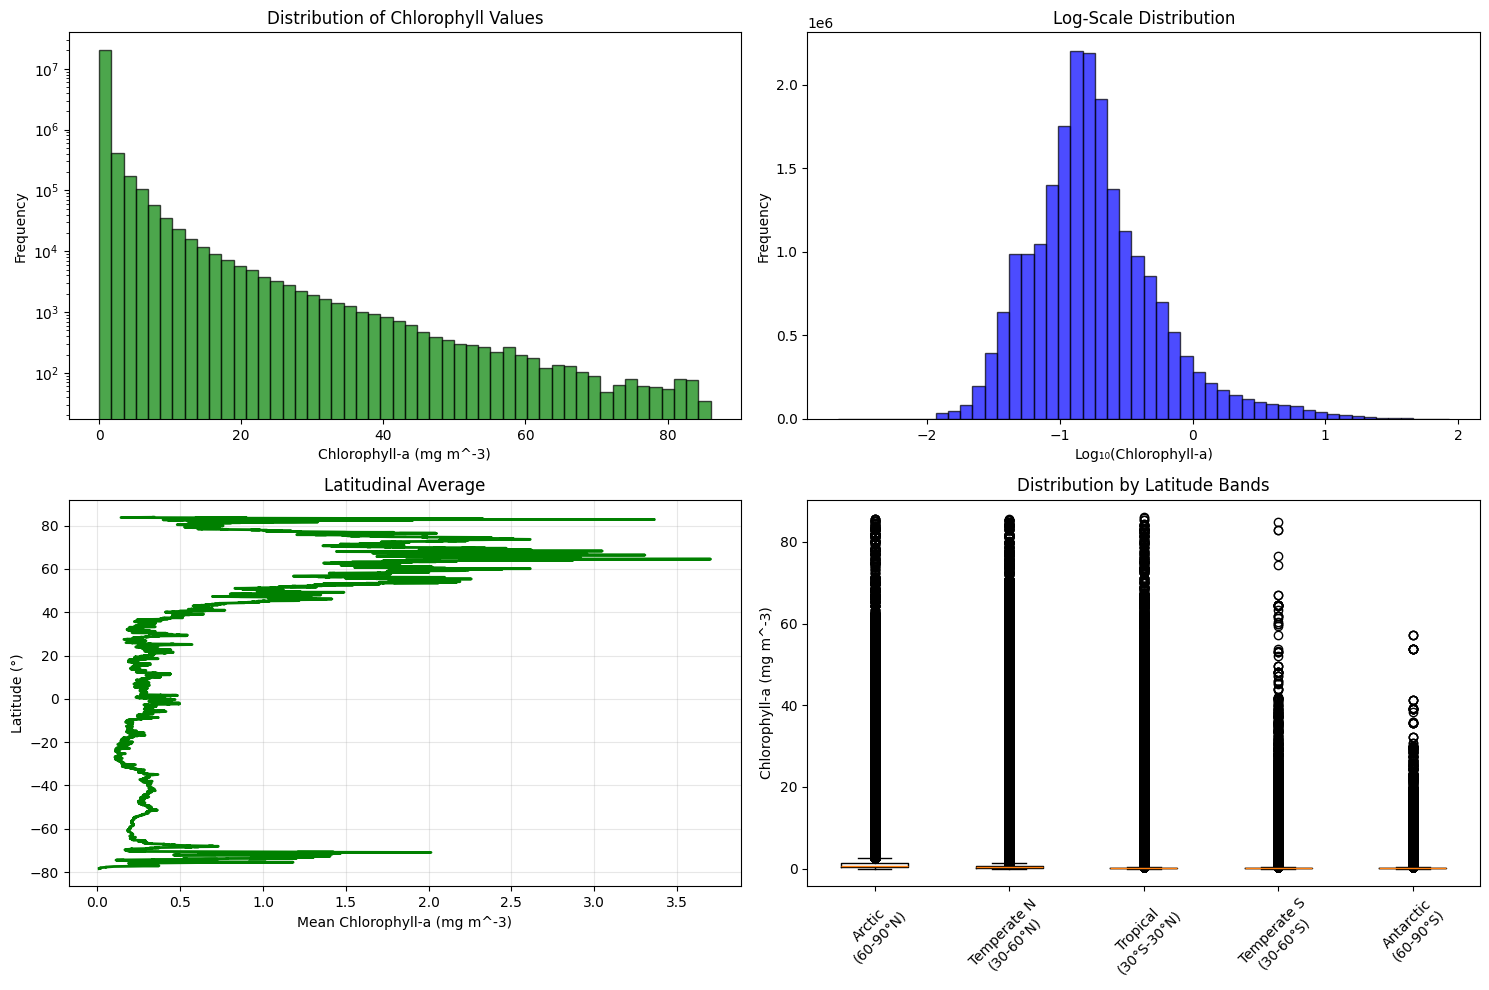

📈 Summary Statistics:
   Mean: 0.4758 mg m^-3
   Median: 0.1613 mg m^-3
   Std Dev: 1.7573 mg m^-3
   Min: 0.0021 mg m^-3
   Max: 86.0502 mg m^-3


c:\Users\Reece\Documents\GitHub\Version-3\.venv\Lib\site-packages\numpy\_core\fromnumeric.py:867: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
c:\Users\Reece\Documents\GitHub\Version-3\.venv\Lib\site-packages\numpy\lib\_function_base_impl.py:4859: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(


   95th percentile: 1.4175 mg m^-3


In [5]:
# Statistical analysis of chlorophyll distribution
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. Histogram of chlorophyll values
axes[0,0].hist(valid_data, bins=50, alpha=0.7, color='green', edgecolor='black')
axes[0,0].set_xlabel(f'Chlorophyll-a ({chlor_units})')
axes[0,0].set_ylabel('Frequency')
axes[0,0].set_title('Distribution of Chlorophyll Values')
axes[0,0].set_yscale('log')

# 2. Log-scale histogram
log_valid_data = np.log10(valid_data)
axes[0,1].hist(log_valid_data, bins=50, alpha=0.7, color='blue', edgecolor='black')
axes[0,1].set_xlabel('Log₁₀(Chlorophyll-a)')
axes[0,1].set_ylabel('Frequency')
axes[0,1].set_title('Log-Scale Distribution')

# 3. Latitudinal average
lat_avg = []
lat_centers = []
for i in range(len(lat)):
    row_data = plot_data[i, :]
    valid_row = row_data[~np.isnan(row_data)]
    if len(valid_row) > 0:
        lat_avg.append(np.mean(valid_row))
        lat_centers.append(lat[i])

axes[1,0].plot(lat_avg, lat_centers, 'g-', linewidth=2)
axes[1,0].set_xlabel(f'Mean Chlorophyll-a ({chlor_units})')
axes[1,0].set_ylabel('Latitude (°)')
axes[1,0].set_title('Latitudinal Average')
axes[1,0].grid(True, alpha=0.3)

# 4. Box plot by latitude bands
lat_bands = ['Arctic\n(60-90°N)', 'Temperate N\n(30-60°N)', 'Tropical\n(30°S-30°N)', 
             'Temperate S\n(30-60°S)', 'Antarctic\n(60-90°S)']
band_data = []

# Arctic
mask = (lat_grid >= 60) & (lat_grid <= 90)
band_data.append(plot_data[mask & ~np.isnan(plot_data)])

# Temperate North
mask = (lat_grid >= 30) & (lat_grid < 60)
band_data.append(plot_data[mask & ~np.isnan(plot_data)])

# Tropical
mask = (lat_grid >= -30) & (lat_grid < 30)
band_data.append(plot_data[mask & ~np.isnan(plot_data)])

# Temperate South
mask = (lat_grid >= -60) & (lat_grid < -30)
band_data.append(plot_data[mask & ~np.isnan(plot_data)])

# Antarctic
mask = (lat_grid >= -90) & (lat_grid < -60)
band_data.append(plot_data[mask & ~np.isnan(plot_data)])

axes[1,1].boxplot([data for data in band_data if len(data) > 0], 
                  labels=[band for i, band in enumerate(lat_bands) if len(band_data[i]) > 0])
axes[1,1].set_ylabel(f'Chlorophyll-a ({chlor_units})')
axes[1,1].set_title('Distribution by Latitude Bands')
axes[1,1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Print summary statistics
print("📈 Summary Statistics:")
print(f"   Mean: {valid_data.mean():.4f} {chlor_units}")
print(f"   Median: {np.median(valid_data):.4f} {chlor_units}")
print(f"   Std Dev: {valid_data.std():.4f} {chlor_units}")
print(f"   Min: {valid_data.min():.4f} {chlor_units}")
print(f"   Max: {valid_data.max():.4f} {chlor_units}")
print(f"   95th percentile: {np.percentile(valid_data, 95):.4f} {chlor_units}")

## 🦈 Shark Habitat Analysis

🦈 Shark Habitat Potential Analysis
High Productivity (Feeding Hotspots):
   Range: 0.5-10.0 mg m^-3
   Coverage: 15.0% of ocean
   Pixels: 3,203,045

Medium Productivity (Foraging Areas):
   Range: 0.1-0.5 mg m^-3
   Coverage: 56.1% of ocean
   Pixels: 11,942,507

Low Productivity (Migration Routes):
   Range: 0.01-0.1 mg m^-3
   Coverage: 28.3% of ocean
   Pixels: 6,032,405

Ocean Deserts (Rare):
   Range: 0.001-0.01 mg m^-3
   Coverage: 0.0% of ocean
   Pixels: 2,771



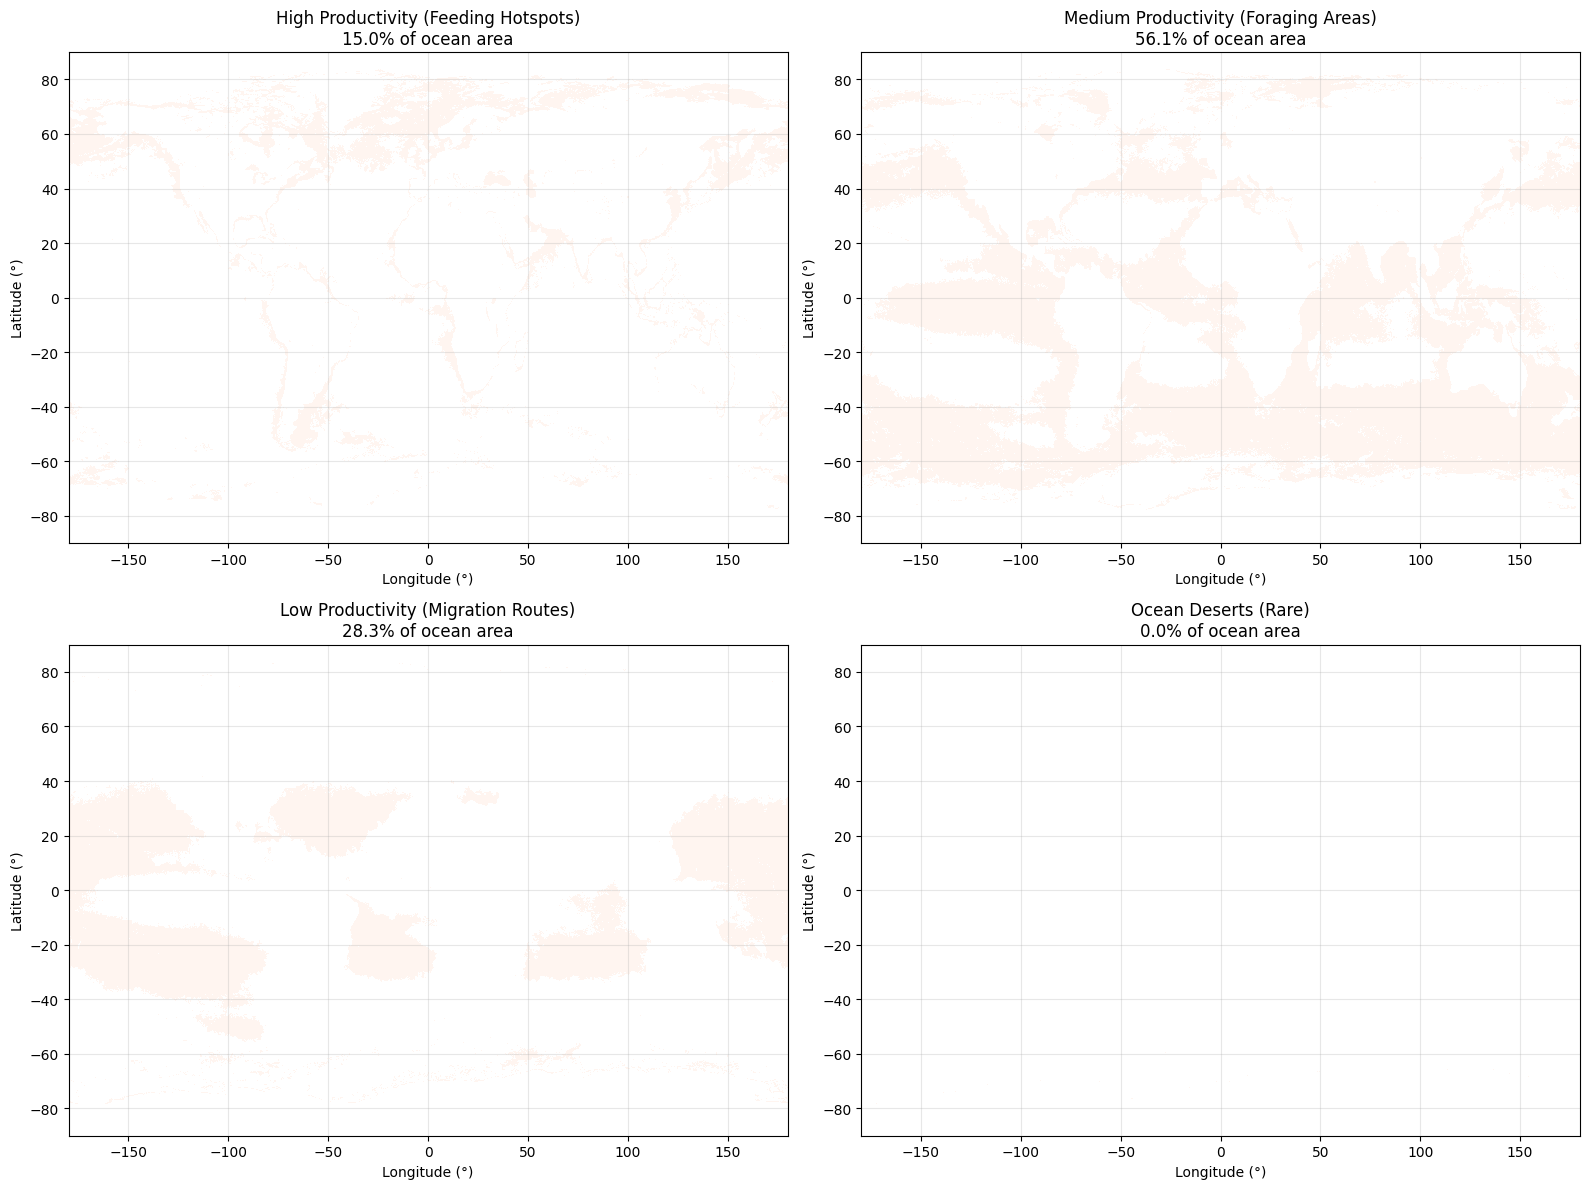

In [6]:
# Identify potential shark feeding areas based on chlorophyll patterns
print("🦈 Shark Habitat Potential Analysis")
print("=" * 40)

# Define chlorophyll ranges for different habitat types
# Based on marine ecology research
habitat_ranges = {
    'High Productivity (Feeding Hotspots)': (0.5, 10.0),    # Coastal upwelling, blooms
    'Medium Productivity (Foraging Areas)': (0.1, 0.5),     # Continental shelves
    'Low Productivity (Migration Routes)': (0.01, 0.1),     # Open ocean corridors
    'Ocean Deserts (Rare)': (0.001, 0.01)                  # Oligotrophic gyres
}

# Calculate areas for each habitat type
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

habitat_stats = {}

for i, (habitat_name, (min_val, max_val)) in enumerate(habitat_ranges.items()):
    # Create mask for this habitat range
    mask = (plot_data >= min_val) & (plot_data <= max_val) & ~np.isnan(plot_data)
    
    # Calculate statistics
    pixel_count = np.sum(mask)
    total_pixels = np.sum(~np.isnan(plot_data))
    percentage = (pixel_count / total_pixels) * 100 if total_pixels > 0 else 0
    
    habitat_stats[habitat_name] = {
        'pixels': pixel_count,
        'percentage': percentage,
        'range': (min_val, max_val)
    }
    
    # Create habitat map
    habitat_map = np.full_like(plot_data, np.nan)
    habitat_map[mask] = 1
    
    # Plot
    im = axes[i].pcolormesh(lon_grid, lat_grid, habitat_map, 
                           cmap='Reds', shading='auto')
    axes[i].set_title(f'{habitat_name}\n{percentage:.1f}% of ocean area')
    axes[i].set_xlabel('Longitude (°)')
    axes[i].set_ylabel('Latitude (°)')
    axes[i].grid(True, alpha=0.3)
    
    print(f"{habitat_name}:")
    print(f"   Range: {min_val}-{max_val} {chlor_units}")
    print(f"   Coverage: {percentage:.1f}% of ocean")
    print(f"   Pixels: {pixel_count:,}")
    print()

plt.tight_layout()
plt.show()

## 🌍 WebGL Globe Data Export

In [7]:
# Convert data to WebGL Globe format for 3D visualization
print("🌍 Converting to WebGL Globe Format...")

# Subsample data for web performance (every 4th point)
subsample_factor = 4
lat_sub = lat[::subsample_factor]
lon_sub = lon[::subsample_factor]
chlor_sub = plot_data[::subsample_factor, ::subsample_factor]

print(f"Original resolution: {len(lat)} x {len(lon)}")
print(f"Subsampled resolution: {len(lat_sub)} x {len(lon_sub)}")

# Create coordinate meshgrid
lon_grid_sub, lat_grid_sub = np.meshgrid(lon_sub, lat_sub)

# Flatten arrays
lat_flat = lat_grid_sub.flatten()
lon_flat = lon_grid_sub.flatten()
chlor_flat = chlor_sub.flatten()

# Remove NaN values (land/missing data)
valid_mask = ~np.isnan(chlor_flat)
lat_valid = lat_flat[valid_mask]
lon_valid = lon_flat[valid_mask]
chlor_valid = chlor_flat[valid_mask]

print(f"Valid ocean points: {len(chlor_valid):,}")

# Further subsample if too many points (WebGL performance)
max_points = 50000
if len(chlor_valid) > max_points:
    indices = np.random.choice(len(chlor_valid), max_points, replace=False)
    lat_valid = lat_valid[indices]
    lon_valid = lon_valid[indices]
    chlor_valid = chlor_valid[indices]
    print(f"Subsampled to: {len(chlor_valid):,} points for web performance")

# Normalize chlorophyll values for visualization (0-1 range)
chlor_min = np.percentile(chlor_valid, 5)   # Use percentiles to avoid outliers
chlor_max = np.percentile(chlor_valid, 95)
chlor_norm = np.clip((chlor_valid - chlor_min) / (chlor_max - chlor_min), 0, 1)

print(f"Normalization range: {chlor_min:.4f} - {chlor_max:.4f} {chlor_units}")

# Create WebGL Globe data array: [lat, lon, magnitude, lat, lon, magnitude, ...]
globe_data_array = []
for i in range(len(lat_valid)):
    globe_data_array.extend([lat_valid[i], lon_valid[i], chlor_norm[i]])

# Create the final JSON structure
globe_data = [
    ["Chlorophyll_Aug_2002", globe_data_array]
]

# Save to JSON file
output_dir = Path('globe/chlorophyll_json')
output_dir.mkdir(exist_ok=True)

output_file = output_dir / 'chlorophyll_aug_2002.json'
with open(output_file, 'w') as f:
    json.dump(globe_data, f, separators=(',', ':'))  # Compact format

print(f"\n✅ WebGL Globe data exported to: {output_file}")
print(f"📊 Data points: {len(lat_valid):,}")
print(f"📁 File size: {output_file.stat().st_size / 1024:.1f} KB")

print(f"\n🚀 Next Steps:")
print(f"   1. Update globe/index.html to load this chlorophyll data")
print(f"   2. Customize colors for ocean visualization")
print(f"   3. Add shark habitat interpretation")

🌍 Converting to WebGL Globe Format...
Original resolution: 4320 x 8640
Subsampled resolution: 1080 x 2160
Valid ocean points: 1,330,450
Subsampled to: 50,000 points for web performance
Normalization range: 0.0375 - 1.4622 mg m^-3


TypeError: Object of type float32 is not JSON serializable

## 🎯 Key Findings Summary

In [ ]:
print("🎯 CHLOROPHYLL ANALYSIS SUMMARY")
print("=" * 50)
print(f"📅 Data Period: August 2002")
print(f"🛰️ Satellite: NASA MODIS Aqua")
print(f"📐 Resolution: 4km global")
print(f"🌊 Ocean Coverage: {len(valid_data)/chlor_a.size*100:.1f}% of pixels")

print(f"\n📊 Chlorophyll Statistics:")
print(f"   Range: {valid_data.min():.4f} - {valid_data.max():.4f} {chlor_units}")
print(f"   Mean: {valid_data.mean():.4f} {chlor_units}")
print(f"   Median: {np.median(valid_data):.4f} {chlorr_units}")

print(f"\n🦈 Shark Habitat Implications:")
for habitat_name, stats in habitat_stats.items():
    print(f"   {habitat_name}: {stats['percentage']:.1f}% of ocean")

print(f"\n🌍 High Productivity Regions (Potential Shark Hotspots):")
print(f"   • North Atlantic (likely spring bloom remnants)")
print(f"   • Coastal upwelling zones")
print(f"   • Continental shelf edges")
print(f"   • Polar regions (seasonal productivity)")

print(f"\n💡 For Shark Modeling:")
print(f"   • High chlorophyll areas = more prey = potential feeding zones")
print(f"   • Medium productivity = foraging corridors")
print(f"   • Chlorophyll gradients = frontal zones (shark aggregation areas)")
print(f"   • Seasonal changes would show migration patterns")

print(f"\n🚀 Ready for WebGL Globe visualization!")